In [2]:
exec(open("../../../python/FNC_init.py").read())

[**Demo %s**](#demo-diffadv-advdiff)


The first step is to define a discretization of the domain.

In [3]:
m, n = 50, 36
x, Dx, Dxx = FNC.diffcheb(m, [-1, 1])
y, Dy, Dyy = FNC.diffcheb(n, [-1, 1])
mtx, X, Y, _, _, _ = FNC.tensorgrid(x, y)
u_init = lambda x, y: (1 + y) * (1 - x)**4 * (1 + x)**2 * (1 - y**4)

There are really two grids now: the full grid and the subset grid of interior points. Since the IVP unknowns are on the interior grid, that is the one we need to change shapes on. We also need the functions `extend` and `chop` to add and remove boundary values.

In [4]:
_, _, _, vec, unvec, _ = FNC.tensorgrid(x[1:-1], y[1:-1])

def chop(U):
    return U[1:-1, 1:-1]

def extend(U):
    UU = zeros((m+1, n+1))
    UU[1:-1, 1:-1] = U
    return UU

pack = lambda U: vec(chop(U))          # restrict to interior, then vectorize
unpack = lambda u: extend(unvec(u))    # unvectorize, then extend to boundary


Now we can define and solve the IVP using a stiff solver.

In [5]:
from scipy.integrate import solve_ivp
ep = 0.05
def dw_dt(t, w):
    U = unpack(w)
    Uyy = Dxx @ U
    Uxx = U @ Dyy.T 
    dU_dt = 1 - Dx @ U + ep * (Uxx + Uyy)
    return pack(dU_dt)

U0 = mtx(u_init)
sol = solve_ivp(dw_dt, (0, 2), pack(U0), method="BDF", dense_output=True)

When we evaluate the solution at a particular value of $t$, we get a vector of the interior grid values. The same `unpack` function above converts this to a complete matrix of grid values.

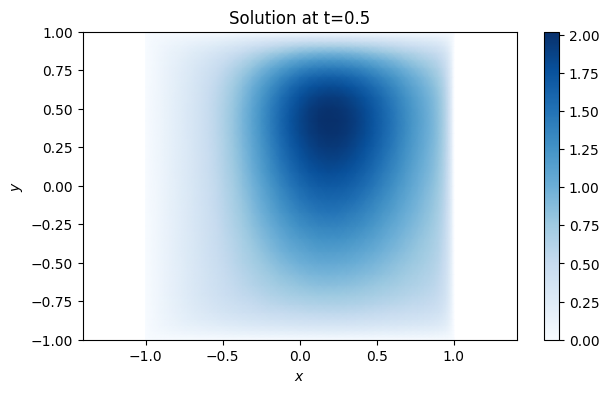

In [6]:
U = lambda t: unpack(sol.sol(t))    # function of time on the grid

pcolormesh(X.T, Y.T, U(0.5).T, cmap="Blues", shading="gouraud")
colorbar()
xlabel("$x$"),  ylabel("$y$")
axis("equal"),  title("Solution at t=0.5");

In [7]:
from matplotlib import animation
fig, ax = subplots()
obj = ax.pcolormesh(X.T, Y.T, U(0).T, vmin=0, vmax=2, cmap="Blues", shading="gouraud")
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.set_xlabel("$x$"),  ax.set_ylabel("$y$")
ax.set_aspect("equal")
ax.set_title("Advection-diffusion in 2d")
def snapshot(t):
    global obj
    obj.remove()
    obj = ax.pcolormesh(X.T, Y.T, U(t).T, vmin=0, vmax=2, cmap="Blues", shading="gouraud")
    time_text.set_text(f"t = {t:.2f}")

anim = animation.FuncAnimation(fig, snapshot, frames=linspace(0, 2, 91))
anim.save("advdiff-2d.mp4", fps=30)
close()